# **소개**

matplotlib를 사용한 [Mercari 가격 제안 챌린지](https://www.kaggle.com/c/mercari-price-suggestion-challenge#description)의 초기 설명 데이터 분석입니다. [bokeh](https://bokeh.pydata.org/en/latest/) 및 [Plot.ly](https://plot.ly/feed/) - 아름다운 대화형 플롯과 대시보드를 생성하는 시각화 도구입니다. 이 대회는 일본 최대 커뮤니티 기반 쇼핑 앱인 Mercari가 주최하며, 주요 목표는 Mercari가 상품 정보를 바탕으로 판매자에게 제안해야 하는 정확한 가격을 예측하는 것입니다.

클러스터링 주제에 대한 사전 처리 문서 및 기계 학습 기술(K-평균 및 LDA)에 대한 지침을 제공합니다. 이 커널은 두 부분으로 나뉩니다.

1. 탐색적 데이터 분석
2. 텍스트 처리
    2.1. 토큰화 및 tf-idf 알고리즘
    2.2. K-평균 클러스터링
    2.3. 잠재 디리클레 할당(LDA) / 주제 모델링

In [1]:
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
#import lda

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import _stop_words

from collections import Counter
#from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

# **탐색 데이터 분석**
데이터를 처음 보면 고유 식별자(item_id) 외에 이 모델에는 7개의 변수가 있습니다. 이 노트북은 간단한 통계 요약과 함께 각각을 순차적으로 살펴볼 것입니다.

1. **수치적/연속적 특징**
     1. 가격: 항목의 최종 입찰 가격. 이것은 테스트 세트에서 예측해야 하는 응답/독립 변수가 될 것입니다.
     2. 배송비
 
1. **카테고리 특징**:
     1. 배송비 : 판매자가 배송비를 부담하면 1, 구매자가 부담하면 0
     2. item_condition_id : 판매자가 제공한 상품의 상태
     1. name : 아이템의 이름
     2. brand_name : 아이템의 생산자 브랜드명
     2. category_name: "\"로 구분된 항목의 단일 또는 다중 범주
     3. item_description: 제거된 단어를 포함할 수 있는 항목에 대한 간단한 설명, [rm] 표시

In [7]:
!pip install py7zr
import py7zr
import os

with py7zr.SevenZipFile("./input/train.tsv.7z", 'r') as archive:
    archive.extractall(path="./input/")

with py7zr.SevenZipFile("./input/test.tsv.7z", 'r') as archive:
    archive.extractall(path="./input/")

In [2]:
PATH = "./input/"

In [3]:
train = pd.read_csv(f'{PATH}train.tsv', sep='\t')
test = pd.read_csv(f'{PATH}test.tsv', sep='\t')

In [4]:
# size of training and dataset
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [5]:
# different data types in the dataset: categorical (strings) and numeric
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [6]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## Target Variable: **Price**

다음 표준 검사는 응답 또는 target 변수를 사용하는 것입니다. 이 경우 Mercari의 마켓플레이스 판매자에게 제안하는 '가격'입니다. 교육에 포함된 모든 항목의 중앙값은 약 267달러이지만 일부 극단값이 100달러 이상이고 최대값이 2,009달러인 경우 변수의 분포가 왼쪽으로 크게 치우쳐 있습니다. 따라서 가격에 대한 로그 변환을 수행해 보겠습니다(0 및 음수 값을 피하기 위해 변환 전에 값에 +1을 추가했습니다).

In [7]:
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

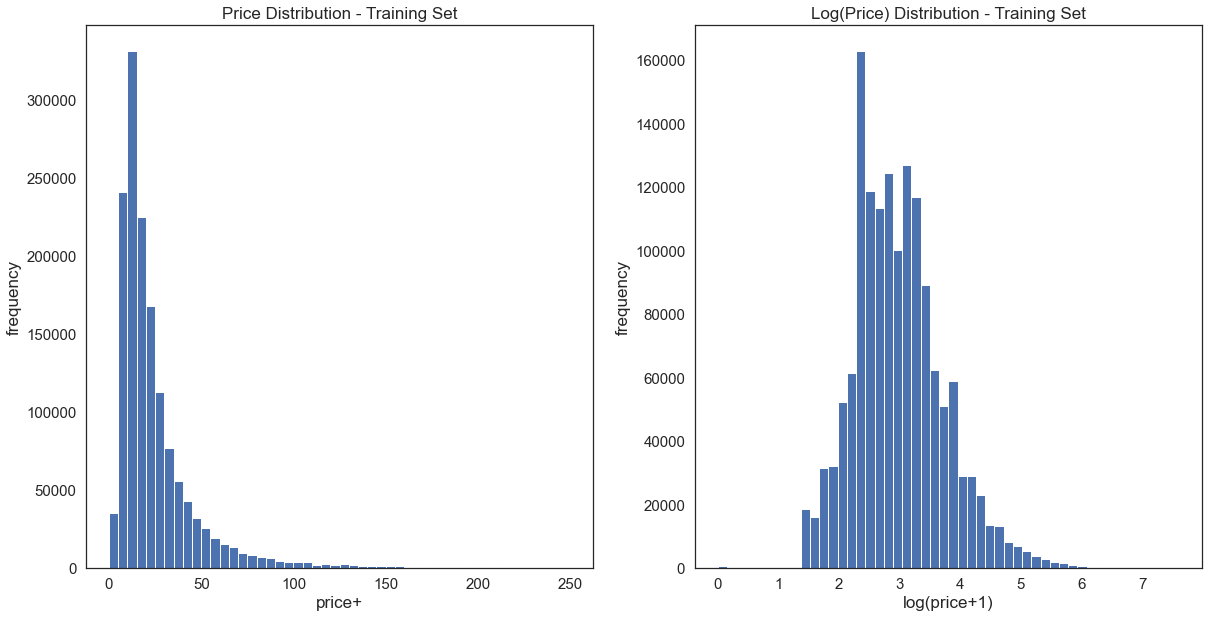

In [8]:
# 원래
plt.subplot(1, 2, 1)
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price+', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

# 로그 스케일
plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

## **Shipping**

배송료 부담은 판매자와 구매자가 적절하게 분할하여 상품 배송비의 절반 이상을 판매자가 부담합니다(55%). 또한 배송비를 부담해야 하는 사용자가 지불하는 평균 가격은 추가 배송비가 필요하지 않은 사용자보다 저렴합니다. 이는 판매자가 추가 배송을 보상하기 위해 더 낮은 가격이 필요하다는 우리의 인식과 일치합니다.

In [9]:
train.shipping.value_counts()/len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

In [10]:
prc_shipBySeller = train.loc[train.shipping==1, 'price']
prc_shipByBuyer = train.loc[train.shipping==0, 'price']

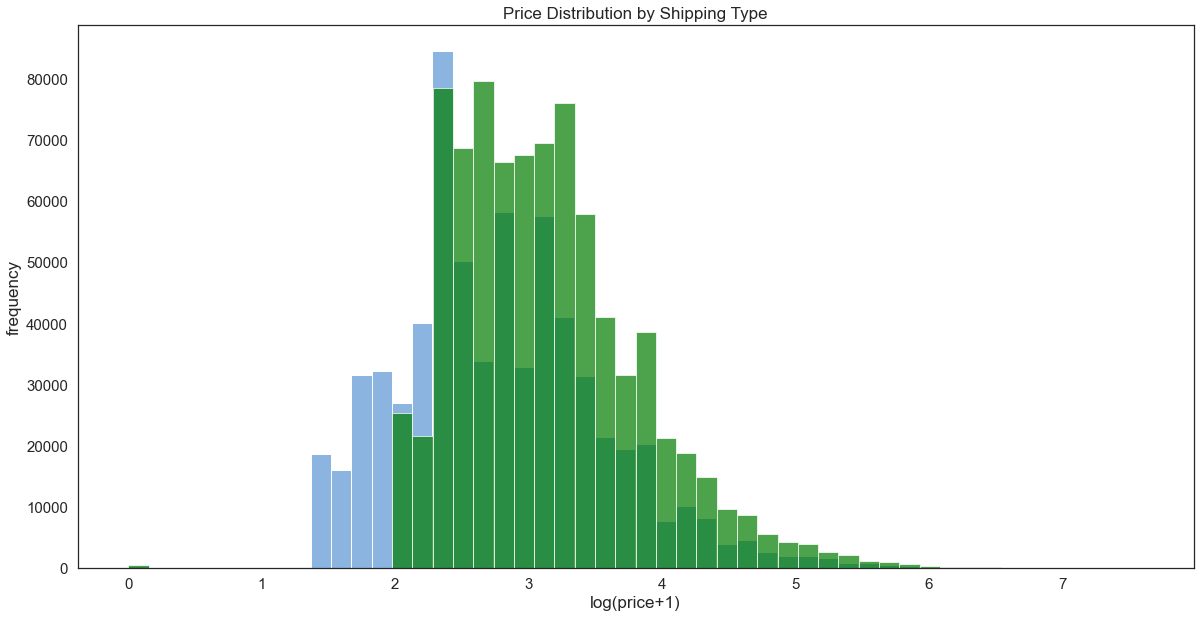

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(prc_shipBySeller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(prc_shipByBuyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

## **Item Category**

약 **1,287**개의 고유한 카테고리가 있지만 각각의 카테고리 중에서 항상 메인/일반 카테고리가 먼저 표시되고 그 다음 두 개의 특정 하위 카테고리(예: 뷰티/메이크업/페이스 또는 립)가 표시됩니다. 이 외에도 카테고리 라벨이 없는 상품이 약 6,327개 있습니다. 카테고리를 세 개의 다른 열로 분할해 보겠습니다. 나중에 우리는 이 정보가 판매자의 관점에서 실제로 매우 중요하며 `brand_name` 열에서 누락된 정보를 처리하는 방법이 모델의 예측에 영향을 미친다는 것을 알게 될 것입니다.

In [12]:
print("There are %d unique values in the category column." % train['category_name'].nunique())

There are 1287 unique values in the category column.


In [13]:
# TOP 5 RAW CATEGORIES
train['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [14]:
# missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

There are 6327 items that do not have a label.


In [15]:
# reference: BuryBuryZymon at https://www.kaggle.com/maheshdadhich/i-will-sell-everything-for-free-0-55
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [16]:
train['general_cat'], train['subcat_1'], train['subcat_2'] = \
zip(*train['category_name'].apply(lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [17]:
# repeat the same step for the test set
test['general_cat'], test['subcat_1'], test['subcat_2'] = \
zip(*test['category_name'].apply(lambda x: split_cat(x)))

In [18]:
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())

There are 114 unique first sub-categories.


In [19]:
print("There are %d unique second sub-categories." % train['subcat_2'].nunique())

There are 871 unique second sub-categories.


전반적으로 **7개의 주요 카테고리**(첫 번째 하위 카테고리에서 114개, 두 번째 하위 카테고리에서 871개)가 있습니다. 여성 및 뷰티 아이템이 가장 인기 있는 두 카테고리(관찰의 50% 이상)이고 그 다음이 어린이입니다. 전자 제품.

In [ ]:
x = train['general_cat'].value_counts().index.values.astype('str')
y = train['general_cat'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))]

In [ ]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [ ]:
x = train['subcat_1'].value_counts().index.values.astype('str')[:15]
y = train['subcat_1'].value_counts().values[:15]
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))][:15]

In [ ]:
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by Sub Category (Top 15)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='SubCategory'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

가격 책정(가격 로그) 관점에서 모든 카테고리는 매우 잘 분포되어 있으며 특별한 가격 책정 포인트가 있는 카테고리는 없습니다.

In [ ]:
general_cats = train['general_cat'].unique()
x = [train.loc[train['general_cat']==cat, 'price'] for cat in general_cats]

In [ ]:
data = [go.Box(x=np.log(x[i]+1), name=general_cats[i]) for i in range(len(general_cats))]

In [ ]:
layout = dict(title="Price Distribution by General Category",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Category'))
fig = dict(data=data, layout=layout)
py.iplot(fig)

## **Brand Name**

In [ ]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

In [ ]:
x = train['brand_name'].value_counts().index.values.astype('str')[:10]
y = train['brand_name'].value_counts().values[:10]

In [ ]:
# trace1 = go.Bar(x=x, y=y, 
#                 marker=dict(
#                 color = y,colorscale='Portland',showscale=True,
#                 reversescale = False
#                 ))
# layout = dict(title= 'Top 10 Brand by Number of Items',
#               yaxis = dict(title='Brand Name'),
#               xaxis = dict(title='Count'))
# fig=dict(data=[trace1], layout=layout)
# py.iplot(fig)

## **Item Description**

이 특정 항목은 구조화되지 않은 데이터이므로 구문 분석하는 것이 더 어려울 것입니다. 더 자세하고 긴 설명이 더 높은 입찰가를 초래한다는 것을 의미합니까? 모든 구두점을 제거하고 일부 영어 불용어(예: "a", "the" 등의 중복 단어) 및 길이가 3 미만인 기타 단어를 제거합니다.

In [25]:
def wordCount(text):
    # convert to lower case and strip regex
    try:
         # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove words in stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

In [ ]:
# add a column of word counts to both the training and test set
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

In [ ]:
train.head()

In [ ]:
df = train.groupby('desc_len')['price'].mean().reset_index()

In [ ]:
trace1 = go.Scatter(
    x = df['desc_len'],
    y = np.log(df['price']+1),
    mode = 'lines+markers',
    name = 'lines+markers'
)
layout = dict(title= 'Average Log(Price) by Description Length',
              yaxis = dict(title='Average Log(Price)'),
              xaxis = dict(title='Description Length'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

또한 항목 설명(4개의 관찰에는 설명이 없음)에 누락된 값이 있는지 확인하고 교육 세트에서 해당 관찰을 제거해야 합니다.

In [ ]:
train.item_description.isnull().sum()

In [ ]:
# remove missing values in item description
train = train[pd.notnull(train['item_description'])]

In [ ]:
# create a dictionary of words for each category
cat_desc = dict()
for cat in general_cats: 
    text = " ".join(train.loc[train['general_cat']==cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)

# flat list of all words combined
flat_lst = [item for sublist in list(cat_desc.values()) for item in sublist]
allWordsCount = Counter(flat_lst)
all_top10 = allWordsCount.most_common(20)
x = [w[0] for w in all_top10]
y = [w[1] for w in all_top10]

In [ ]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Word Frequency',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Word'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

카테고리별로 가장 일반적인 단어를 보면 ***size***, ***free*** 및 ***shipping***이 판매자가 매우 일반적으로 사용한다는 것을 알 수 있습니다. 이는 '가격'과 '배송비' 두 변수 사이에 상관관계가 거의 없다는(또는 배송비가 가격의 차이를 설명하지 않음) 이전에 보여준 것과 모순되는 고객 유치 의도입니다. ***브랜드 이름***도 상당히 중요한 역할을 했습니다. 이는 네 가지 범주 모두에서 가장 인기 있는 것 중 하나입니다.

# **Text Processing - Item Description**
*
The following section is based on the tutorial at https://ahmedbesbes.com/how-to-mine-newsfeed-data-and-extract-interactive-insights-in-python.html*

## **전처리: 토큰화**

대부분의 경우 NLP 프로젝트의 첫 번째 단계는 문서를 **"토큰화"**하는 것이며 주요 목적은 텍스트를 정규화하는 것입니다. 세 가지 기본 단계에는 일반적으로 다음이 포함됩니다.
* 설명을 문장으로 나눈 다음 문장을 토큰으로 나눕니다.
* 구두점 및 중지 단어 제거
* 토큰 소문자
* 여기에서는 길이가 3자 이상인 단어만 고려합니다.

In [ ]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [ ]:
# apply the tokenizer into the item descriptipn column
train['tokens'] = train['item_description'].map(tokenize)
test['tokens'] = test['item_description'].map(tokenize)

In [ ]:
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

토크나이저가 설명을 잘 정리했는지에 대한 예를 살펴보겠습니다.

In [ ]:
for description, tokens in zip(train['item_description'].head(),
                              train['tokens'].head()):
    print('description:', description)
    print('tokens:', tokens)
    print()

'WordCloud' 패키지를 사용하여 각 카테고리 내에서 빈도가 가장 높은 단어를 쉽게 시각화할 수도 있습니다.

In [ ]:
# build dictionary with key=category and values as all the descriptions related.
cat_desc = dict()
for cat in general_cats: 
    text = " ".join(train.loc[train['general_cat']==cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)


# find the most common words for the top 4 categories
women100 = Counter(cat_desc['Women']).most_common(100)
beauty100 = Counter(cat_desc['Beauty']).most_common(100)
kids100 = Counter(cat_desc['Kids']).most_common(100)
electronics100 = Counter(cat_desc['Electronics']).most_common(100)

In [ ]:
def generate_wordcloud(tup):
    wordcloud = WordCloud(background_color='white',
                          max_words=50, max_font_size=40,
                          random_state=42
                         ).generate(str(tup))
    return wordcloud

In [ ]:
fig,axes = plt.subplots(2, 2, figsize=(30, 15))

ax = axes[0, 0]
ax.imshow(generate_wordcloud(women100), interpolation="bilinear")
ax.axis('off')
ax.set_title("Women Top 100", fontsize=30)

ax = axes[0, 1]
ax.imshow(generate_wordcloud(beauty100))
ax.axis('off')
ax.set_title("Beauty Top 100", fontsize=30)

ax = axes[1, 0]
ax.imshow(generate_wordcloud(kids100))
ax.axis('off')
ax.set_title("Kids Top 100", fontsize=30)

ax = axes[1, 1]
ax.imshow(generate_wordcloud(electronics100))
ax.axis('off')
ax.set_title("Electronic Top 100", fontsize=30)

## **Pre-processing:  tf-idf**

tf-idf는 **Term Frequency–inverse Document Frequency**의 약어입니다. 문서 또는 말뭉치 모음의 어휘와 관련하여 특정 단어의 중요성을 수량화합니다. 측정항목은 다음 두 가지 요소에 따라 달라집니다.
- **용어 빈도**: 주어진 문서에서 단어의 출현(예: 단어 모음)
- **역 문서 빈도**: 문서 모음에서 단어가 나타나는 역수

다음과 같이 생각해 보십시오. 단어가 모든 문서에서 광범위하게 사용되는 경우 특정 문서 내에서 그 존재가 문서 자체에 대한 많은 특정 정보를 제공할 수 없습니다. 따라서 두 번째 용어는 "a", "the", "and" 등과 같은 일반적인 단어에 불이익을 주는 벌칙 용어로 볼 수 있습니다. 따라서 tf-idf는 특정 문서의 단어 관련성에 대한 가중치 체계로 볼 수 있습니다. .

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,
                             max_features=180000,
                             tokenizer=tokenize,
                             ngram_range=(1, 2))

In [ ]:
all_desc = np.append(train['item_description'].values, test['item_description'].values)
vz = vectorizer.fit_transform(list(all_desc))

vz는 tfidf 행렬입니다. 여기서:
* 행 수는 전체 설명 수입니다.
* 컬럼 수는 설명 전체에 걸쳐 고유한 토큰의 총 수입니다.

In [ ]:
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

아래는 가장 낮은 tfidf 점수를 가진 10개의 토큰입니다. 이는 놀랍게도 하나의 설명을 다른 설명과 구별하는 데 사용할 수 없는 매우 일반적인 단어입니다.

In [ ]:
tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

아래는 가장 높은 tfidf 점수를 가진 10개의 토큰입니다. 여기에는 매우 구체적인 단어가 포함되어 있어 단어를 보면 해당 단어가 속한 범주를 추측할 수 있습니다.

In [ ]:
tfidf.sort_values(by=['tfidf'], ascending=False).head(10)

tfidf 행렬의 높은 차원을 감안할 때 SVD(특이 값 분해) 기술을 사용하여 차원을 줄여야 합니다. 그리고 어휘를 시각화하기 위해 다음으로 t-SNE를 사용하여 차원을 50에서 2로 줄일 수 있습니다. t-SNE는 차원을 2 또는 3으로 줄이는 데 더 적합합니다.

### **t-분산 확률적 이웃 임베딩(t-SNE)**

t-SNE는 고차원 데이터 세트의 시각화에 특히 적합한 차원 축소 기술입니다. 목표는 고차원 공간에서 점 세트를 가져와 저차원 공간, 일반적으로 2D 평면에서 해당 점의 표현을 찾는 것입니다. 데이터 내의 구조를 찾기 위해 이웃 그래프에서 랜덤 워크가 있는 확률 분포를 기반으로 합니다. 그러나 t-SNE 복잡성이 상당히 높기 때문에 일반적으로 t-SNE를 적용하기 전에 다른 고차원 축소 기술을 사용합니다.

먼저 t-SNE를 실행하는 데 시간이 매우 오래 걸릴 수 있으므로 교육 및 테스트 항목 설명에서 샘플을 가져오겠습니다. 그런 다음 SVD를 사용하여 각 벡터의 차원을 n_components(50)로 줄일 수 있습니다.

In [ ]:
trn = train.copy()
tst = test.copy()
trn['is_train'] = 1
tst['is_train'] = 0

sample_sz = 15000

combined_df = pd.concat([trn, tst])
combined_sample = combined_df.sample(n=sample_sz)
vz_sample = vectorizer.fit_transform(list(combined_sample['item_description']))

In [ ]:
from sklearn.decomposition import TruncatedSVD

n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

이제 t-SNE를 사용하여 차원을 50에서 2로 줄일 수 있습니다!

In [ ]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)

In [ ]:
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

이제 데이터 포인트를 시각화할 수 있습니다. 클러스터의 크기와 편차는 t-SNE에서 정보가 거의 없음을 의미합니다.

In [ ]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600,
                       title="tf-idf clustering of the item description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [ ]:
combined_sample.reset_index(inplace=True, drop=True)

In [ ]:
tfidf_df = pd.DataFrame(tsne_tfidf, columns=['x', 'y'])
tfidf_df['description'] = combined_sample['item_description']
tfidf_df['tokens'] = combined_sample['tokens']
tfidf_df['category'] = combined_sample['general_cat']

In [ ]:
plot_tfidf.scatter(x='x', y='y', source=tfidf_df, alpha=0.7)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "tokens": "@tokens", "category":"@category"}
show(plot_tfidf)

## **K-Means Clustering**

K-평균 클러스터링 목표는 클러스터 중심에서 문서/설명의 평균 제곱 유클리드 거리를 최소화하는 것입니다.

In [ ]:
from sklearn.cluster import MiniBatchKMeans

num_clusters = 30 # need to be selected wisely
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters,
                               init='k-means++',
                               n_init=1,
                               init_size=1000, batch_size=1000, verbose=0, max_iter=1000)

In [ ]:
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)

In [ ]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(num_clusters):
    print("Cluster %d:" % i)
    aux = ''
    for j in sorted_centroids[i, :10]:
        aux += terms[j] + ' | '
    print(aux)
    print() 

이 클러스터를 표시하려면 먼저 tsne를 사용하여 거리의 차원을 2로 줄여야 합니다.

In [ ]:
# repeat the same steps for the sample
kmeans = kmeans_model.fit(vz_sample)
kmeans_clusters = kmeans.predict(vz_sample)
kmeans_distances = kmeans.transform(vz_sample)
# reduce dimension to 2 using tsne
tsne_kmeans = tsne_model.fit_transform(kmeans_distances)

In [ ]:
colormap = np.array(["#6d8dca", "#69de53", "#723bca", "#c3e14c", "#c84dc9", "#68af4e", "#6e6cd5",
"#e3be38", "#4e2d7c", "#5fdfa8", "#d34690", "#3f6d31", "#d44427", "#7fcdd8", "#cb4053", "#5e9981",
"#803a62", "#9b9e39", "#c88cca", "#e1c37b", "#34223b", "#bdd8a3", "#6e3326", "#cfbdce", "#d07d3c",
"#52697d", "#194196", "#d27c88", "#36422b", "#b68f79"])

In [ ]:
#combined_sample.reset_index(drop=True, inplace=True)
kmeans_df = pd.DataFrame(tsne_kmeans, columns=['x', 'y'])
kmeans_df['cluster'] = kmeans_clusters
kmeans_df['description'] = combined_sample['item_description']
kmeans_df['category'] = combined_sample['general_cat']
#kmeans_df['cluster']=kmeans_df.cluster.astype(str).astype('category')

In [ ]:
plot_kmeans = bp.figure(plot_width=700, plot_height=600,
                        title="KMeans clustering of the description",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [ ]:
source = ColumnDataSource(data=dict(x=kmeans_df['x'], y=kmeans_df['y'],
                                    color=colormap[kmeans_clusters],
                                    description=kmeans_df['description'],
                                    category=kmeans_df['category'],
                                    cluster=kmeans_df['cluster']))

plot_kmeans.scatter(x='x', y='y', color='color', source=source)
hover = plot_kmeans.select(dict(type=HoverTool))
hover.tooltips={"description": "@description", "category": "@category", "cluster":"@cluster" }
show(plot_kmeans)

## **잠재 디리클레 할당**

LDA(Latent Dirichlet Allocation)는 말뭉치에 있는 주제를 발견하는 데 사용되는 알고리즘입니다.

> LDA는 고정된 수의 주제에서 시작합니다. 각 주제는 단어에 대한 분포로 표시되고 각 문서는 주제에 대한 분포로 표시됩니다. 토큰 자체는 의미가 없지만 주제에서 제공하는 단어에 대한 확률 분포는 문서에 포함된 다양한 아이디어에 대한 감각을 제공합니다.
>
> 참조: https://medium.com/intuitionmachine/the-two-paths-from-natural-language-processing-to-artificial-intelligence-d5384ddbfc18

입력은 **단어 모음**입니다. 즉, 각 문서는 말뭉치의 단어 수가 포함된 각 열이 있는 행으로 표시됩니다. LDA를 위한 대화형 시각화를 제공하는 pyLDAvis라는 강력한 도구를 사용할 것입니다.

In [ ]:
cvectorizer = CountVectorizer(min_df=4,
                              max_features=180000,
                              tokenizer=tokenize,
                              ngram_range=(1,2))

In [ ]:
cvz = cvectorizer.fit_transform(combined_sample['item_description'])

In [ ]:
lda_model = LatentDirichletAllocation(n_components=20,
                                      learning_method='online',
                                      max_iter=20,
                                      random_state=42)

In [ ]:
X_topics = lda_model.fit_transform(cvz)

In [ ]:
n_top_words = 10
topic_summaries = []

topic_word = lda_model.components_  # get the topic words
vocab = cvectorizer.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

In [ ]:
# reduce dimension to 2 using tsne
tsne_lda = tsne_model.fit_transform(X_topics)

In [ ]:
unnormalized = np.matrix(X_topics)
doc_topic = unnormalized/unnormalized.sum(axis=1)

lda_keys = []
for i, tweet in enumerate(combined_sample['item_description']):
    lda_keys += [doc_topic[i].argmax()]

lda_df = pd.DataFrame(tsne_lda, columns=['x','y'])
lda_df['description'] = combined_sample['item_description']
lda_df['category'] = combined_sample['general_cat']
lda_df['topic'] = lda_keys
lda_df['topic'] = lda_df['topic'].map(int)

In [ ]:
plot_lda = bp.figure(plot_width=700,
                     plot_height=600,
                     title="LDA topic visualization",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

In [ ]:
source = ColumnDataSource(data=dict(x=lda_df['x'], y=lda_df['y'],
                                    color=colormap[lda_keys],
                                    description=lda_df['description'],
                                    topic=lda_df['topic'],
                                    category=lda_df['category']))

plot_lda.scatter(source=source, x='x', y='y', color='color')
hover = plot_kmeans.select(dict(type=HoverTool))
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips={"description":"@description",
                "topic":"@topic", "category":"@category"}
show(plot_lda)

In [ ]:
def prepareLDAData():
    data = {
        'vocab': vocab,
        'doc_topic_dists': doc_topic,
        'doc_lengths': list(lda_df['len_docs']),
        'term_frequency':cvectorizer.vocabulary_,
        'topic_term_dists': lda_model.components_
    } 
    return data

*참고: pyLDAvis를 사용하여 시각화의 HTML을 넣으면 커널의 레이아웃이 왜곡되는 것이 유감입니다. 여기에는 업로드하지 않겠습니다. 그러나 아래 코드를 따르면 주제 클러스터의 공간과 각 주제 내의 용어 구성 요소를 시각화하는 매우 흥미로운 대화형 거품 차트로 생성된 HTML 파일이 있을 것입니다.*

![](https://farm5.staticflickr.com/4536/38709272151_7128c577ee_h.jpg)

In [ ]:
import pyLDAvis

lda_df['len_docs'] = combined_sample['tokens'].map(len)
ldadata = prepareLDAData()
pyLDAvis.enable_notebook()
prepared_data = pyLDAvis.prepare(**ldadata)

<a data-flickr-embed="true"  href="https://www.flickr.com/photos/thykhuely/38709272151/in/dateposted-public/" title="pyLDAvis"><img src="https://farm5.staticflickr.com/4536/38709272151_7128c577ee_h.jpg" width="1600" height="976" alt="pyLDAvis"></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>

In [ ]:
import IPython.display
from IPython.core.display import display, HTML, Javascript

#h = IPython.display.display(HTML(html_string))
#IPython.display.display_HTML(h)